# Transcription Rate vs Gene Size

In this Jupyter notebooke, we explore whether and to what extend NET-seq data might be biased by the size of the transcript. This is based on the discovery that the NET-seq signal [1] declines as a function of distance from the TSS. It could potentially indicate a bias induced by the protocol, which covers always a similar range around the TSS, e.g. 500 bp. Thus, it covers larger fraction of small genes than of large genes and makes it seemingly associated to the transcription length.

To exclude this possibility, we compare the data with Pol2 ChIP-seq [2], which we assume to reasonably represent transcription. Both transcription rate measurements are correlated to the size as well as to each other.

**Conclusion**: Although NET-seq data is seemingly showing a higher correlation to gene size than Pol2 ChIP-seq, both are strongly correlated to each other. Since we use only two classes in our study (i.e. high transciption vs low transcription), the majority of genes fall into the same group. Thus, the results and conclusions are assumed to be relatively unaffected.

## Load Python Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from dcor import distance_correlation
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datahandler import reader

## Define Functions

In [2]:
def load_transcript():
    curr_dir = os.getcwd()
    tss = pd.read_csv(
        '%s/data/ref/GSE49026_S-TSS.txt' % curr_dir,
        delimiter='\t',
        usecols=['chr', 'coordinate', 'ORF']
    )
    tss.columns = ['chr', 'start', 'ORF']
    pas = pd.read_csv(
        '%s/data/ref/GSE49026_S-PAS.txt' % curr_dir,
        delimiter='\t',
        usecols=['coordinate', 'ORF']
    )
    pas.columns = ['end', 'ORF']
    return pd.merge(left=tss, right=pas, left_on='ORF', right_on='ORF').sort_values(by='ORF')

In [3]:
def fetch_data(
    trans_df,
    net_neg,
    net_pos,
    pol2_data,
):
    net_tr = []
    pol2_tr = []
    for row in trans_df.iterrows():
        row = row[1]
        direct = '+' if row['start'] <= row['end'] else '-'
        if direct == '+':
            pol2_tr.append(np.nanmean(pol2_data.values(row['chr'], row['start'], row['end'])))  
            if np.isnan(np.nanmean(net_pos.values(row['chr'], row['start'], row['end']))):
                net_tr.append(0)
            else:
                net_tr.append(np.nanmean(net_pos.values(row['chr'], row['start'], row['end'])))
        else:
            pol2_tr.append(np.nanmean(pol2_data.values(row['chr'], row['end'], row['start'])))
            if np.isnan(np.nanmean(net_neg.values(row['chr'], row['end'], row['start']))):
                net_tr.append(0)
            else:
                net_tr.append(np.nanmean(net_neg.values(row['chr'], row['end'], row['start'])))    
            
    return (
        np.asarray(net_tr, dtype='float').reshape(-1),
        np.asarray(pol2_tr, dtype='float').reshape(-1)
    )

In [4]:
def trim_data(data, rm_percentile=5):
    lower, upper = np.percentile(data, [0, 100. - rm_percentile])
    mask = np.logical_and(data >= lower, data <= upper)
    return mask

In [5]:
def frequency_bins(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1), np.arange(nlen), np.sort(x))

## Load Data

In [6]:
net_neg_bw = reader.load_big_file('data/seq/wt_netseq_minus.bw', is_abs_path=True)
net_pos_bw = reader.load_big_file('data/seq/wt_netseq_plus.bw', is_abs_path=True)

pol2_data_bw = reader.load_big_file('data/seq/L5_8_chip_rpb1_med17wt.bw', is_abs_path=True)

trans_df = load_transcript()

In [7]:
trans_df['size'] = np.abs(trans_df['start'] - trans_df['end']).to_numpy()

In [8]:
(net_tr, pol2_tr) = fetch_data(trans_df, net_neg_bw, net_pos_bw, pol2_data_bw)

/tmp/ipykernel_19091/4269417409.py:20: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(net_neg.values(row['chr'], row['end'], row['start']))):
/tmp/ipykernel_19091/4269417409.py:14: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(net_pos.values(row['chr'], row['start'], row['end']))):


## Filter for the 95th Percentile and Discretise Data 

In [9]:
data_mask = np.ones(len(trans_df.index), dtype='bool')
data_mask = np.logical_and(data_mask, trim_data(trans_df['size']))
data_mask = np.logical_and(data_mask, trim_data(net_tr))
data_mask = np.logical_and(data_mask, trim_data(pol2_tr))

In [10]:
num_bin = 50
net_tr = np.digitize(net_tr[data_mask], frequency_bins(net_tr[data_mask], num_bin))
pol2_tr = np.digitize(pol2_tr[data_mask], frequency_bins(pol2_tr[data_mask], num_bin))
size = np.digitize(trans_df['size'][data_mask], frequency_bins(trans_df['size'][data_mask], num_bin))

## Determine Correlation and Visualise

### Correlation Transcription Rate vs Size

In [11]:
dc_net = distance_correlation(size, net_tr)
dc_pol2 = distance_correlation(size, pol2_tr)

print('Distance correlation with size')
print('NET-seq:\t\t %.3f' % dc_net)
print('Pol2 ChIP-seq:\t\t %.3f' % dc_pol2)

/home/leo/.local/lib/python3.8/site-packages/dcor/_fast_dcov_avl.py:317: UserWarning: Falling back to uncompiled AVL fast distance covariance because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(f"Falling back to uncompiled AVL fast distance "


Distance correlation with size
NET-seq:		 0.321
Pol2 ChIP-seq:		 0.224


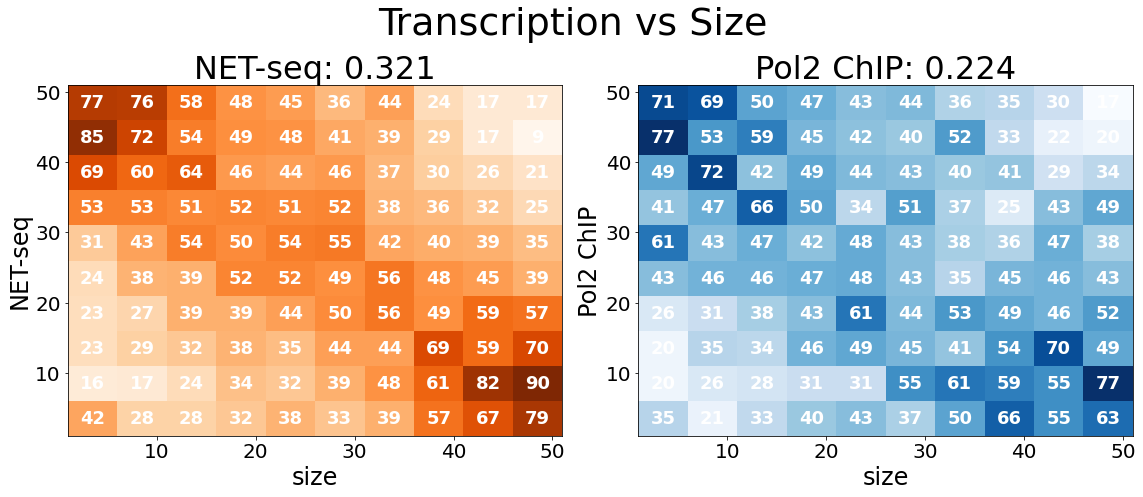

In [12]:
hist_bin = 10
shift = num_bin /(hist_bin * 2)
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
hist_net, x_s_net, y_s_net, _ = ax[0].hist2d(size, net_tr, cmap='Oranges')
for i in range(len(y_s_net)-1):
    for j in range(len(x_s_net)-1):
        ax[0].text(x_s_net[j] + shift, y_s_net[i] + shift, int(hist_net.T[i,j]), color="w",
                      ha="center", va="center", fontweight="bold", fontsize=18
                     )
        
hist_pol2, x_s_pol2, y_s_pol2, _ = ax[1].hist2d(size, pol2_tr, cmap='Blues')
for i in range(len(y_s_pol2)-1):
    for j in range(len(x_s_pol2)-1):
        ax[1].text(x_s_pol2[j] + shift, y_s_pol2[i] + shift, int(hist_pol2.T[i,j]), color="w",
                      ha="center", va="center", fontweight="bold", fontsize=18
                     )
for a in ax:
    a.set_xlabel('size', fontsize=24)
    a.tick_params(axis='x', labelsize=20)
    a.tick_params(axis='y', labelsize=20)

ax[0].set_ylabel('NET-seq', fontsize=24)
ax[1].set_ylabel('Pol2 ChIP', fontsize=24)
ax[0].set_title('NET-seq: %.3f' % dc_net, fontsize=32)
ax[1].set_title('Pol2 ChIP: %.3f' % dc_pol2, fontsize=32)
fig.suptitle('Transcription vs Size', fontsize=38)
fig.tight_layout()
plt.savefig('figures/examples/tr_vs_size.png')

### Correlation NET-seq vs Pol2 ChIP-seq

In [13]:
dc_net_pol2 = distance_correlation(net_tr, pol2_tr)

print('Distance correlation between NET-seq and Pol2 ChIP-seq:\t\t %.3f' % dc_net_pol2)

Distance correlation between NET-seq and Pol2 ChIP-seq:		 0.750


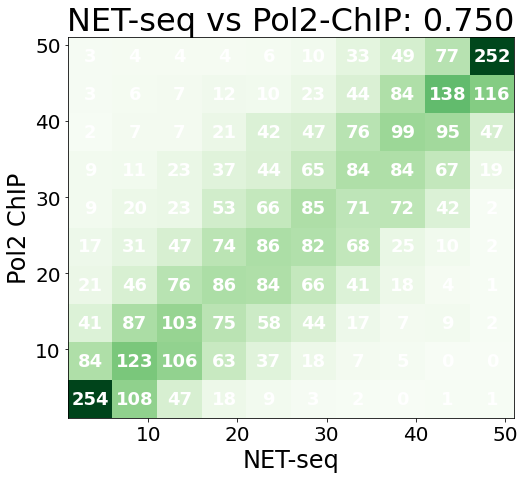

In [14]:
plt.figure(figsize=(8, 7))
hist_tr, x_tr, y_tr, _ = plt.hist2d(net_tr, pol2_tr, cmap='Greens')
for i in range(len(y_tr)-1):
    for j in range(len(x_tr)-1):
        plt.text(x_tr[j] + shift, y_tr[i] + shift, int(hist_tr.T[i,j]), color="w",
                      ha="center", va="center", fontweight="bold", fontsize=18
                     )
plt.xlabel('NET-seq', fontsize=24)
plt.ylabel('Pol2 ChIP', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('NET-seq vs Pol2-ChIP: %.3f' % dc_net_pol2, fontsize=32)
plt.savefig('figures/examples/tr_correlation.png')

## References
[1] Harlen, Kevin M., et al. "Comprehensive RNA polymerase II interactomes reveal distinct and varied roles for each phospho-CTD residue." Cell reports 15.10 (2016): 2147-2158.

[2] Georges, Adrien, et al. "Functional interplay between Mediator and RNA polymerase II in Rad2/XPG loading to the chromatin." Nucleic acids research 47.17 (2019): 8988-9004.